# 02477 Bayesian Machine Learning - Exercise 1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import seaborn as snb
from typing import NamedTuple
from typing import Tuple

from scipy.stats import binom as binom_dist
from scipy.stats import beta as beta_dist
from scipy.special import beta as beta_fun

snb.set_style('darkgrid')
snb.set(font_scale=1.5)
plt.rcParams['lines.linewidth'] = 3


# Introduction

The purpose of this exercise is to become familiar with the core components of Bayesian inference: the **prior**, the **likelihood**, **posterior** and **the model evidence**. We will also re-cap various ways to summarize distributions, e.g. **mean**, **mode**, **variance**, and **intervals**, and we will look into how to compute and manipulate probabilities using sampling. We will study these concepts in the context of the **Beta-Binomial** model, which is the "Hello world"-equivalent of Bayesian statistics.

One of the main applications of the Beta-Binomial model is to **estimate proportions**. For example, suppose a website shows a specific ad to $N = 112$ customers and $y = 13$ of those costumers end up clicking on the ad. A common task is then to estimate the click-rate for this ad in order to answer questions like the following:

1) What is the probability that the next customer will click on the ad?

2) What is the probability that the click-rate is below 10%?

We will see how the Bayesian Beta-Binomial model can be used to answer such questions. Furthermore, we will conclude the exercise by studying a slightly more general version of the problem: Suppose a website has two ads: version A and version B and that version A was shown $N_A$ times and generated $y_A$ clicks, whereas version B was shown $N_B$ times and generated $y_B$ click. What is the probability that the click-rate of version B is larger than click-rate of version A?

We highly encourage you to **discuss your results and conclusions with one of the teachers/teaching assistant to check you understanding**. Moreover, if you get stuck with an exercise, don't hesitate to consult the solution or the teachers/teaching assistant.

**Content**

- Part 1: Maximum likelihood estimation
- Part 2: Bayesian inference
- Part 3: The functional form of Beta distributions
- Part 4: Computing summary statistics and probabilities using sampling
- Part 5: Application to A/B testing


**Note on JaX**

In this course, we will be using the [JaX-framework](https://github.com/jax-ml/jax) for numerical computations. The module `jax.numpy` implements an interface very similar to the familiar `numpy` for basic operations, but JaX is much faster than numpy and JaX also features GPU support, automatic differentiation, just-in-time compilations, and many other advanced features. However, we won't be using the advanced features of JaX in this course. The biggest difference between `jnp.numpy` and `numpy` is how random number generation is handled, but we will get into that later.

We typically use

`import jax.numpy as jnp`

to remind ourselves that we are working JaX and not regular numpy. 

JaX can be installed via typical packages managing systems (e.g. pip and conda). You can find more information about the specific environments for which these notebooks have been developed and tested on the course page on DTU Learn

For more information about JaX, consult the website: [https://github.com/jax-ml/jax](https://github.com/jax-ml/jax).




## Estimating the proportions using the binomial distribution

In this exercise, we will work with two common families of probabilities distributions: the **Binomial distribution** and the **Beta distribution**. 

### The Binomial distribution and maximum likelihood estimation

First, we re-cap the ***Binomial distribution***. The Binomial distribution is a discrete probability distribution representing the number of successes in a sequence of $N$ **conditionally independent Bernoulli trials** and it is specified through its **probability mass function (PMF)**:

$$
\begin{align*}
p(y|N, \theta) &= \text{Bin}(y|N, \theta)\\
&= {N\choose y} \theta^{y}(1-\theta)^{N-y},
\end{align*}$$

where $N$ is the number of trials, $\theta \in \left[0, 1\right]$ is the probability of success in each individual trial and $y \in \left\lbrace 0, 1, \dots, N \right\rbrace$ is the total number of successes. The quantity ${N\choose y}$ is a called a binomial coefficient and is pronounced "$N$ choose $y$" and counts the number of ways $y$ items can be chosen from a set of $N$ items.

Recall, the mean and variance of a Binomial random variable $y \sim \text{Bin}(y|N, \theta)$ is given by
$$
\begin{align*}
\mathbb{E}\left[y\right] &= N \theta\\
\mathbb{V}\left[y\right] &= N \theta (1-\theta).
\end{align*}$$

 The simplest way to estimate $\theta$ is through **maximum likelihood estimation (MLE)**, which for this model can be done analytically:

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} p(y|N, \theta) = \frac{y}{N}.$$

We can also compute a classic/frequentist 95%-**confidence interval**:

$$\text{CI} = \hat{\theta}_{\text{MLE}} \pm 1.96 \sqrt{\frac{\hat{\theta}_{\text{MLE}}(1-\hat{\theta}_{\text{MLE}})}{N}}.$$

Technically, this type of interval is called a **Wald interval** and relies on a Gaussian approximation, but we won't cover these details in this course. Note that a **confidence interval** is **generally not** the same as a **posterior credibility interval** (see Section 4.6.6 in Murphy1). 


### The beta distribution as prior distribution for the proportion $\theta$

The ***Beta distribution*** is distribution over random variables in the unit interval. The **probability density function (PDF)** of the Beta distribution has two parameters $a > 0$ and $b > 0$ and is given by

$$p(\theta|a,b) = \frac{1}{B(a,b)}\theta^{a-1}(1-\theta)^{b-1},$$

where $B(a, b) > 0$ is a **normalization constant** that ensures that the density integrates to one:

$$B(a,b) = \int \theta^{a-1}(1-\theta)^{b-1} \text{d}\theta = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)},$$

where $\Gamma$ is the so-called gamma function, which we won't dive deeper into in this course.

Since $B(a,b)$ is a constant wrt. $\theta$, it holds that

$$p(\theta|a,b) \propto \theta^{a-1}(1-\theta)^{b-1},$$

and therefore, we say that $f(\theta) = \theta^{a-1}(1-\theta)^{b-1}$ is the **functional form** of a Beta distribution for some $a,b > 0$.

The **mean** of a Beta-distributed random variable, $\theta \sim \text{Beta}(a, b)$, is given by

$$\mathbb{E}\left[\theta\right] = \int_0^1 \theta \, p(\theta|a,b) \,\text{d} \theta  = \frac{a}{a+b}. \tag{1}$$

The quantity $\mathbb{E}\left[\theta\right]$ is also sometimes refered to as the **expected value** of $\theta$ or the **first moment** of $\theta$. The **variance** of $\theta$ is

$$\mathbb{V}\left[\theta\right] = \int_0^1 \left(\theta - \mathbb{E}\left[\theta\right] \right)^2 \, p(\theta|a,b) \,\text{d} \theta  = \frac{a b}{(a+b)^2(a+b+1)}.$$

When $a, b > 1$ the Beta density is **unimodal** (i.e. has a single peak) with the location of the mode (i.e. the location of the peak of the distribution) given by 

$$\theta_{\text{mode}} = \frac{a - 1}{a + b - 2}.$$

If needed, you can find more information about both distributions in Section 2.4.1 (Murphy1) in the textbook or on Wikipedia: 

[https://en.wikipedia.org/wiki/Beta_distribution](https://en.wikipedia.org/wiki/Beta_distribution)

[https://en.wikipedia.org/wiki/Binomial_distribution](https://en.wikipedia.org/wiki/Binomial_distribution)

### The Beta-binomial model ###

We will now introduce our first Bayesian model. The **beta-binomial model** is a Bayesian model for estimating proportions $\theta \in \left[0, 1\right]$, where the **likelihood** is the binomial distribution and a Beta distribution is used as a **prior distribution** for the parameter $\theta$. Moreover, we often use the notation $a_0$ to indicate the $a_0$ is a hyperparameter for the prior distribution.


The key equations for the model are given by

\begin{align*}
    p(\theta) &= \text{Beta}(\theta|a_0, b_0)&&\text{(Prior)}\\
    p(y|\theta) &= {N \choose y} \theta^y (1-\theta)^{N-y}&&\text{(Likelihood)}\\
    p(\theta|y) &= \text{Beta}(\theta|a_0 + y, b_0 + N-y)&&\text{(Posterior)}
  \end{align*}


for the dataset $\mathcal{D} = \left\lbrace N, y \right\rbrace$. 

**Notation**

Following the convention of the book, we will the use both $p(\theta|y)$ and $p(\theta|\mathcal{D})$ to denote the posterior distribution of $\theta$ conditioned on $y$. We will often write $p(\theta)$ to denote the prior instead of $p(\theta|a_0,b_0)$ and usually only use  the latter if we want to highlight the dependency on the hyperparameters $a, b$. 

We will typically refer to $\theta$ as the **parameter** of the model and to $a_0, b_0$ as **hyperparamters** of the model.
 

# Part 1:  Maximum likelihood estimation
Assume you want to estimate the probability of success, $\theta \in \left[0, 1\right]$, after observing $y = 1$ success out of $N = 7$ independent Bernoulli trials. That is, your dataset is given by $\mathcal{D} = \left\lbrace N = 7, y = 1\right\rbrace$.

Let's create a class for representing our data:

In [2]:
class ObservedData(NamedTuple):
    """ Represents an observation from a Binomial distribution Bin(theta|N, y) """
    y:  int
    N:  int

data = ObservedData(y=1, N=7)
print(data)

ObservedData(y=1, N=7)


When the number of trials $N$ is constant, we often abbreviated the binomial likelihood as $p(y|\theta) = \text{Bin}(y|\theta)$, omitting the explicit dependence on $N$.

**Task 1.1**: Evaluate the likelihood $p(y|\theta)$ for $(y, N) = (1, 7)$ and $\theta = \frac{1}{5}.$ 



**Answer 1.1**:

$$
\begin{align*}
    p(y=1|\theta=\frac{1}{5}) & = {7\choose 1}\left(\frac{1}{5}\right)^1\left(\frac{4}{5}\right)^6 = 0.37\\ 
\end{align*}
$$

In [50]:
print(f"{binom_dist.pmf(data.y, data.N, 0.2):.2f}")

0.37


**Task 1.2**: Plot the likelihood $p(y|\theta)$ as a function of $\theta$ for $\theta \in \left[0,1\right]$ and identify the maximum likelihood solution visually/numerically. 

*Hints:*

- *You can either implement the likelihood function yourself using the equation given above, or you can use the implementation from scipy.stats: binom_dist.pmf(y, n, p), where y is the number of success, n is the number of trials and p is the probability of success.*
- *If you don't know how to get started, study the solution.*



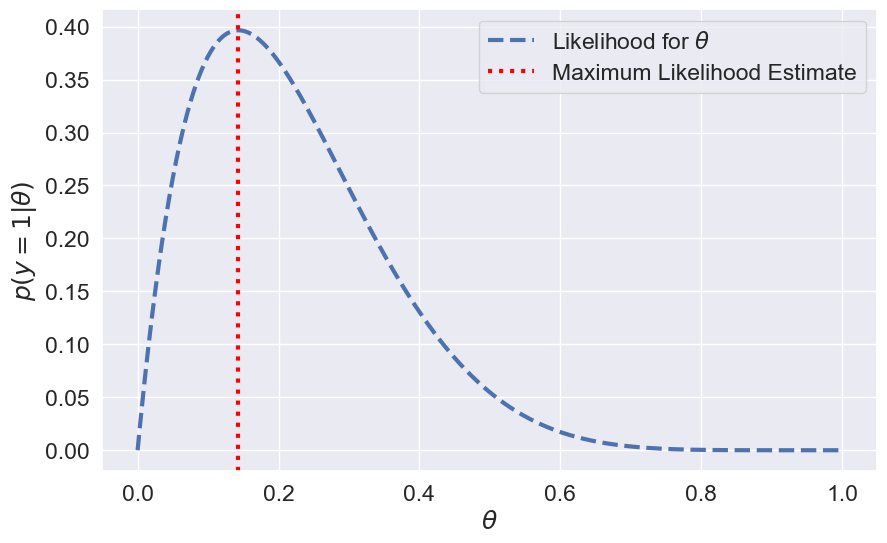

In [38]:
# make grid for plotting the likelihood p(y|theta) in interval [0, 1]
thetas = jnp.linspace(0, 1, 1000)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(thetas, binom_dist.pmf(data.y, data.N, thetas), linestyle='--', label=r'Likelihood for $\theta$')
ax.axvline(x=data.y/data.N, color='red', linestyle=':', label='Maximum Likelihood Estimate')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$p(y=1|\theta)$')
ax.legend()

plt.show()



**Task 1.3**: Compute the maximum likelihood estimate for $\theta$ and compute a 95% confidence interval using the equations given above.



**Task 1.4**: What happens if you had observed $y = 0$ instead of $y = 1$? Does the result seem reasonable?

***Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.**

**Answer 1.3**:

$$\hat{\theta}_{\text{MLE}} = \frac{y}{N} = \frac{1}{7}$$

$$
\begin{align*}
    \text{CI} & = \hat{\theta}_{\text{MLE}} \pm 1.96 \sqrt{\frac{\hat{\theta}_{\text{MLE}}(1-\hat{\theta}_{\text{MLE}})}{N}}\\
    & = 0.14 \pm 0.26
\end{align*}    
$$

In [49]:
theta_mle = data.y / data.N
error = 1.96*((theta_mle*(1-theta_mle))/data.N)**(1/2)
print(f"{theta_mle:.2f}, {error:.2f}")

0.14, 0.26


**Answer 1.4**:


$$
\begin{align*}
    p(y=0|\theta) =  {N\choose 0}(1-\theta)^N = N(1-\theta)^N
\end{align*}
$$

Meaning that the probability of $y=0$ success is $1$ when $\theta=0$.
Sounds reasonable as $\theta=0$ means that the probability of success is zero and no matter how many trials done, $y$ is always $0$.

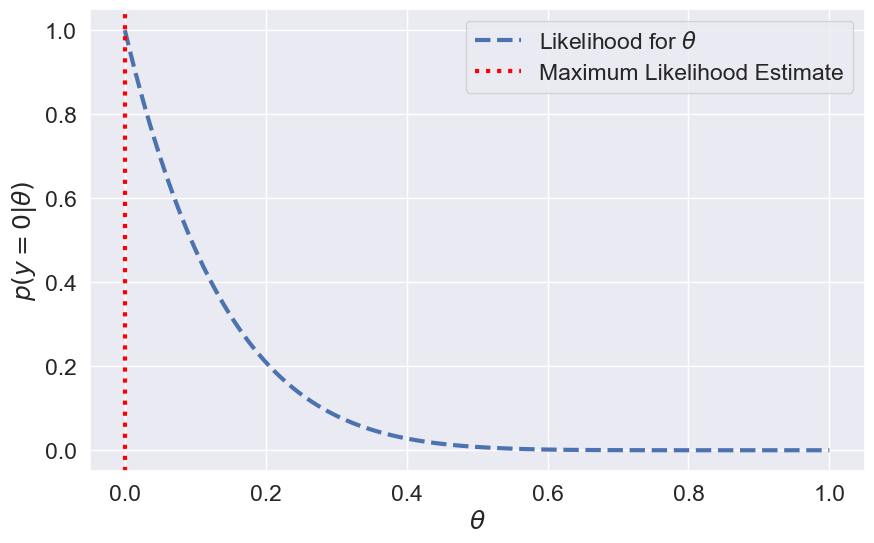

In [64]:
data_test = ObservedData(0, 7)
thetas = jnp.linspace(0, 1, 1000)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(thetas, binom_dist.pmf(data_test.y, data_test.N, thetas), linestyle='--', label=r'Likelihood for $\theta$')
ax.axvline(x=data_test.y/data_test.N, color='red', linestyle=':', label='Maximum Likelihood Estimate')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$p(y=0|\theta)$')
ax.legend()

plt.show()

# Part 2:  Bayesian inference

We are now equipped to study Bayesian inference for $\theta$. Recall, the core concept of Bayesian inference is that we infer a **full probability distribution**  for $\theta$ rather than just a **point estimate** like $\hat{\theta}_{MLE}$. 
As before, your dataset is given by $\mathcal{D} = \left\lbrace N = 7, y = 1\right\rbrace$, but now we will we assume a **uniform** $\text{Beta}(1,1)$ prior distribution for $\theta$, i.e. $p(\theta) = \text{Beta}(\theta|1,1)$.

**Task 2.1**: Compute the **prior** mean and variance of $\theta$, i.e. the mean and variance of $p(\theta) = \text{Beta}\left(\theta|1,1\right)$.




**Task 2.2**: Compute a $50\%$ and a $95\%$ central interval for the prior distribution $p(\theta) = \text{Beta}\left(\theta|1,1\right)$.

*Hints*:

- *An $95\%$ interval $\left[\ell, u\right]$ for $\theta$ satisfies $p(\ell \leq \theta \leq u) = \int_\ell^u p(\theta) d\theta = 0.95.$*
- *For a central interval, the left and right tail will contain the same amount of probability mass, e.g. $p(\theta \leq \ell) = p(\theta \geq u) = 0.025$*
- *For simple Beta-distributions like uniform-distribution in this task, intervals are easy to compute analytically/visually, but for more general Beta-distribution we rely on python like `scipy.stats.beta.interval` as we will see later.*





**Task 2.3**: Compute the parameters $a$ and $b$ of the posterior distribution, i.e. $p(\theta|y)$, using the equations for the Beta-binomial model.






The cell below provides a simple class for representing Beta-distributions. It contains convenient functions such as computing the mean, variance, PDF etc.
Study the code and make sure you understand everything line of code.

In [ ]:
class BetaDistribution(NamedTuple):
    a:  int
    b:  int

    def pdf(self, theta):
        """ returns Beta(theta|a,b) """
        return beta_dist.pdf(theta, a=self.a, b=self.b)
    
    @property
    def mean(self):
        """ returns mean of Beta(a,b)-distribution """
        return self.a/(self.a + self.b)
    
    @property
    def variance(self):
        """ returns variance of Beta(a,b)-distribution """
        return self.a*self.b/(self.a + self.b)**2/(self.a + self.b + 1)
    
    @property
    def mode(self):
        """ returns mode of Beta(a,b)-distribution (assuming it exists) """
        return (self.a - 1)/(self.a+self.b-2)
    
    def get_interval(self, interval_size):
        """ returns a tuple representing a interval_size% credibility interval of Beta(a,b) using scipy.stats.beta.interval  """
        return beta_dist.interval(interval_size/100, a=self.a, b=self.b)
    
    def sample(self, num_samples):
        return beta_dist.rvs(a=self.a, b=self.b, size=num_samples)


prior = BetaDistribution(a=1, b=1)
print(prior)

We can easily summarize Beta-distributions this way:

In [ ]:
print(f'Mean:\t\t{prior.mean:.2f}')
print(f'Variance:\t{prior.variance:.2f}')
print(f'95%-interval:\t[{prior.get_interval(95)[0]:.2f}, {prior.get_interval(95)[1]:.2f}]')
print(f'p(0.5):\t\t{prior.pdf(0.5):.2f}')

**Task 2.4**: Plot the prior density $p(\theta)$, likelihood $p(y|\theta)$, and the posterior density $p(\theta|y)$ as a function of $\theta$ for $\theta \in \left[0, 1\right]$ in the same figure.

*Hints: the functions beta_dist.pdf and binom_dist.pmf might come in handy*




**Task 2.5**: Compute the **MAP-estimator** for $\theta$ and the posterior mean of $\theta$. 

*Hint*: *The MAP-estimator is the mode of the posterior density, i.e. $\theta_{\text{MAP}} = \arg\max\limits_{\theta \in \left[0, 1\right]} p(\theta|y)$*, and can be computed analytically for the Beta-binomoial model.



**Task 2.6**: Compute a 50%, 90% and a 95% posterior credibility interval for $\theta$. Compare the prior and posterior distribution in terms of the summaries (e.g. mean, mode, width of intervals etc.)




**Task 2.7**: In Bayesian statistics, the prior and posterior reflect our knowledge/believe before and after seeing the data, respectively. Compare the summaries for the prior and the posterior and describe qualitatively how our knowledge has changed after seeing the data.

*Hints*
- *Is the location of the distribution affected? Is the spread of the distribution affect? Etc.*

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*


**Task 2.8**: What happens if you had observed $y = 0$ instead of $y = 1$? Does the result seem reasonable?

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*


**Task 2.9**: Experiment with different values of $a_0$, $b_0$, $N$, and $y$ to explore how it affects the results (e.g. the plots, MAP, posterior mean and posterior credibility interval).

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*




In the next few tasks, we will explore the relationships between the posterior mean and the maximum likelihood estimator.

**Task 2.10** Show that the posterior mean converges to the maximum likelihood estimator $\hat{\theta}_{\text{MLE}} = \frac{y}{N}$ as $N \rightarrow \infty$.

*Hints:*
- *Write the posterior mean as a function of $a_0, b_0, N, y$*
- *Write the number of successes as $y = \hat{\theta}_{MLE} N$ and substitute it into the expression for the posterior mean*
- *If you are stuck, don't hesitate to consult the solution or ask the teachers/teaching assistant for an additional hint*





**Task 2.11** Show that the posterior mean is always between the prior mean, $\theta_0 = \frac{a_0}{a_0 + b_0}$, and the maximum likelihood estimate $\hat{\theta}_{MLE} = \frac{y}{N}$.

Hints:
- Show that the posterior mean is a convex combination of the prior mean $\theta_0$ and the maximum likelihood solution $\hat{\theta}_{\text{MLE}}$, i.e. that the posterior mean can be written as 

$$
\begin{align*}
\mathbb{E}\left[\theta|\mathcal{D}\right] = (1-\lambda) \theta_0 + \lambda \hat{\theta}_{MLE}
\end{align*}
$$
for some $0 \leq \lambda \leq 1$.





# Part 3:  The functional form of Beta distributions

Suppose you are given the expression for a probability density function $p_d(\theta)$ up to a constant, i.e. you are told that $p_d(\theta) =   \frac{1}{Z_d}\theta^{36}(1-\theta)^{41}$, where $Z_d > 0$ is an unknown, but positive constant.


**Task 3.1**: Argue the distribution $p_d$ specified above must be a Beta-distribution $p(\theta|a_d, b_d)$ and identify its parameters $a_d, b_d$.






**Task 3.2**: Compute $Z_d$

*Hint: What is the normalization constant for a Beta distribution?*




We will now use our knowledge of the functional form for Beta densities to compute the denominator in Bayes' theorem, $p(y)$, which is often called the **model evidence** or the **marginal likelihood**. It can be expressed using the **product rule** and the **sum rule** of probability theory:

$$\begin{align*}
p(y) = \underbrace{\int p(y, \theta) \text{d}\theta}_{\text{sum rule}} = \int \underbrace{p(y|\theta)p(\theta)}_{\text{product rule}} \text{d}\theta .
\end{align*}
$$

Later in the course, we will see that this term can be useful for hyperparameter tuning and model selection. For most models of practical interest, the term will be **intractable** because we cannot solve the integral above analytically.  However, for models like the beta-binomial we actually compute this term in closed-form.

**Task 3.3**: Compute the analytical expression for the  model evidence for the Beta-Binomial model

**Hints**:
- Insert the probability mass function for the binomial likelihood and the probability density function for the beta distribution in the integral given above.
- Use linearity of integrals to "move" constants (wrt. $\theta$) outside the integral
- Identify the resulting integral as the integral of the functional form corresponding to a Beta density.



# Part 4:  Computing summary statistics and probabilities using sampling

Once, we have obtained our posterior distribution of interest, we often compute the relevant **summary statistics** using **sampling** when the quantities can not easily be computed analytically. We can often generate a set of samples to represent the distribution and then compute the quantities of interest based on the samples. For example,



In [ ]:
# specify parameters for posterior distribution
posterior = BetaDistribution(a=6, b=17)

# generate samples
num_samples = 100000
theta_samples = posterior.sample(num_samples)

# plot
thetas = jnp.linspace(0, 1, 200)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.plot(thetas, posterior.pdf(thetas), label='$p(\\theta|y)$')
ax.hist(theta_samples, 50, density=True, label='Histogram of posterior samples of $\\theta$', alpha=0.5, color='g')
ax.set(xlabel='$\\theta$')
ax.legend();

Using the posterior samples $\theta^{(i)} \sim p(\theta|y)$ for $i = 1, \dots, S$, we can easily **estimate** the posterior mean and variance:

In [ ]:
print(f'E[theta|D] = {jnp.mean(theta_samples):5.4f} (estimated using samples)')
print(f'E[theta|D] = {posterior.mean:5.4f} (analytical solution)\n')
print(f'V[theta|D] = {jnp.var(theta_samples):5.4f} (estimated using samples)')
print(f'V[theta|D] = {posterior.variance:5.4f} (analytical solution)')

Sampling is often easy to implement, and hence, it can also be a highly valuable method for verifying analytical results. 

We can also estimate probabilities and credibility intervals using samples as follows. Suppose we want to estimate the posterior probability that $\theta > 0.2$, then we generate $S$ samples from the posterior, i.e. $\theta^{(i)} \sim p(\theta|\mathcal{D})$ for $i = 1, ..., S$, and then simply count the fraction of samples satisfying $\theta^{(i)} < 0.2$. The reason this works is that we can phrase  the probability as an expectation value, which can be estimated using so-called **Monte Carlo samples**:

$$\begin{align*}
P(\theta > 0.2 | \mathcal{D}) = \int_{0.2}^1 p(\theta|\mathcal{D}) \text{d} \theta = \int_0^1 \mathbb{I}\left[\theta > 0.2\right] p(\theta|\mathcal{D}) \text{d}\theta = \mathbb{E}_{p(\theta|\mathcal{D})}\left[\mathbb{I}\left[\theta > 0.2\right]\right] \approx \frac{1}{S}\sum_{i=1}^S \mathbb{I}\left[\theta^{(i)} > 0.2\right],
\end{align*}$$
where $\mathbb{I}\left[\cdot\right]$ is the indicator function yielding $1$ if the condition in the brackets are true, and 0 otherwise. We will talk much more about Monte Carlo sampling later in the course, but for now, we will simply use it as tool to summarize distributions:

In [ ]:
print(f'P[theta > 0.2|D] = {jnp.mean(theta_samples > 0.2):5.4f}\t\t\t(estimated using sampling)\n')

interval = jnp.percentile(theta_samples, jnp.array([2.5, 97.5]))
print(f'95% credibility interval: [{interval[0]:4.3f}, {interval[1]:4.3f}]\t(estimated using sampling)')

Generally, the larger number of samples $S$ used, the more accurate an estimate we will get. Later in the course, we will make this statement much more precise.

**Example**

A friend of yours is building a classifier for a company, and she asks for your help to evaluate the model. On an independent test set of $N = 100$ examples, the classifier made $y = 8$ errors.  It is critical for the company that the error rate is below 10%. Your friend argues that the error rate is $\frac{8}{100} = 0.08$, so there no need to worry, but you are not as convinced because of the rather small test set.

Let $\theta$ represent the error rate and assume a flat Beta-prior, i.e. $a_0 = b_0 = 1$. 

**Task 4.1**: Compute the posterior mean of the error rate $\theta$.






**Task 4.2**: Generate $S = 10000$ samples from the posterior distribution and estimate the posterior probability of the test error being larger than $10%$.  Comment on the result.




# Part 5:  Application to A/B testing



Suppose a website has two ads: version A and version B and that version A was shown $N_A = 947$ times and generated $y_A = 87$ clicks, whereas version B was shown $N_B = 1053$ times and generated $y_B = 101$ click.

We will now put everything together and apply it do a Bayesian analysis of the data using the Beta-binomial model. 

**Task 5.1** Assuming a $\text{Beta}(\theta|2, 2)$ prior for both $\theta_A$ and $\theta_B$, plot the posterior density for both ads.



**Task 5.2** Estimate the mean and a 95%-credibility interval for both ads. Use a $p(\theta) = \text{Beta}(\theta|2, 2)$ prior for both ads.




**Task 5.3** Generate $S = 10000$ posterior samples for both ads and plot the histograms of both sets of samples.




**Task 5.4** Compute posterior samples for the difference of $\theta_D = \theta_B - \theta_A$ and visualize the histogram





**Task 5.5** Compute the posterior mean and 95% credibility interval for $\theta_D$ using the posterior samples



**Task 5.6** What is the posterior probability that the click-rate of version B is larger than click-rate of version A?



As we have seen, Monte Carlo estimation is a very convenient and flexible tool for estimating quantities of for distributions of interest. In the last part, we will study the estimation error of Monte Carlo estimation. 

For simplicity, we will estimate the mean of a Beta-distribution using sampling. We know that the mean of a $\text{Beta}(a,b)$ distribution is $\mathbb{E}\left[\theta\right] = \frac{a}{a+b}$, and hence, we can compare our Monte Carlo estimate to the true value. Later in the course, we will study sampling methods more formally, and we will see that the expected error of Monte Carlo estimates of the mean of $\theta$ decays as $\sqrt{\frac{\mathbb{V}\left[\theta\right]}{S}}=\mathcal{O}\left(\frac{1}{\sqrt{S}}\right)$, where $S$ is the number of i.i.d. samples and $\mathbb{V}\left[\theta\right]$ is the variance of $\theta$.

**Task 5.7**: Design a small experiment to investigate this numerically, e.g. compare the Monte Carlo estimate of $\mathbb{E}\left[\theta\right]$ to the true value as a function of the sample size.

*Hints*
- *Generate a large number of samples, say $S=10^5$, from a beta distribution $\theta^{(i)} \sim \text{Beta}(a,b)$ for $i = 1, \dots, S$, and compute the running mean of the samples as a function of $S$*. 
- *Plot the estimated mean and compare to the actual mean*
- *Plot the error of the estimate and compare with the theoretical quantity.*
- *Since this experiment depends on random numbers, consider plotting 5-10 realizations.*
- *The function `jnp.cumsum` might come in handy.*

